In [5]:
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt
import struct
import pandas
from pysofia import svm_train, svm_predict, learner_type, loop_type, eta_type
from scipy import stats
from skimage.measure import shannon_entropy
from skimage.filters import threshold_otsu
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize'] = [16, 16]

/home/sean/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
subclavia = np.load("/home/sean/Documents/Development/deep_light_field_interp/res/subclavia.npy")
mri_front = np.load("/home/sean/Documents/Development/deep_light_field_interp/res/mriheadfront.npy")
mri_top = np.load("/home/sean/Documents/Development/deep_light_field_interp/res/mriheadtop.npy")
mri_side = np.load("/home/sean/Documents/Development/deep_light_field_interp/res/mriheadside.npy")

In [1]:
def calculate_entropy_values(slices):
    results = np.zeros(slices.shape[0])

    for i in range(len(slices)):
        thresh = np.mean(slices[i])
#         thresh = 128
        mri_slice = np.squeeze(slices[i, :, :])
#         binary_image = mri_slice > thresh
    #     binary_image = mri_slice // 64
    #     binary_image = mri_slice * 64
        value = shannon_entropy(mri_slice)
        if not np.isinf(value):
            results[i] = value
    
    return results

In [3]:
def calculate_entropy_values_binary(slices):
    results = np.zeros(slices.shape[0])

    for i in range(len(slices)):
        thresh = np.mean(slices[i])
#         thresh = 128
        mri_slice = np.squeeze(slices[i, :, :])
        binary_image = mri_slice > thresh
    #     binary_image = mri_slice // 64
    #     binary_image = mri_slice * 64
        value = shannon_entropy(binary_image)
        if not np.isinf(value):
            results[i] = value
    
    return results

In [8]:
entropy_subclavia_real = calculate_entropy_values(subclavia)
entropy_top_real = calculate_entropy_values(mri_top)
entropy_side_real = calculate_entropy_values(mri_side)
entropy_front_real = calculate_entropy_values(mri_front)

order_subclavia_real = np.arange(96, dtype=np.float)
order_top_real = np.arange(256, dtype=np.float)
order_side_real = np.arange(256, dtype=np.float)
order_front_real = np.arange(256, dtype=np.float)

In [9]:
entropy_subclavia = calculate_entropy_values_binary(subclavia)
entropy_top = calculate_entropy_values_binary(mri_top)
entropy_side = calculate_entropy_values_binary(mri_side)
entropy_front = calculate_entropy_values_binary(mri_front)

order_subclavia = np.arange(96, dtype=np.float)
order_top = np.arange(256, dtype=np.float)
order_side = np.arange(256, dtype=np.float)
order_front = np.arange(256, dtype=np.float)

/home/sean/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


In [11]:
def get_rank_rep(X, y):
    query_id = np.ones(len(X))
    
    y = np.float64(y)
    X = np.float64(np.reshape(X, (X.shape[0], X.shape[1] * X.shape[2])))
    coef = svm_train(X, y, query_id, 1., X.shape[0], X.shape[1],
                         learner_type.logreg, loop_type.rank,
                         eta_type.basic_eta, max_iter=10000)
    
    prediction = svm_predict(X, coef)
    tau, _ = stats.kendalltau(y, prediction)
#     assert np.abs(1 - tau) > 1e-3
    return coef

In [12]:
def get_rank_image(data, orders, img_size):
    rep = get_rank_rep(data, orders)
    rep = np.reshape(rep, img_size)
    return rep

In [13]:
def save_inc_reps(X, y, filename, img_size):
    num_reps = X.shape[0] // 16
    reps = np.zeros((num_reps, img_size[0], img_size[1]), dtype=np.float32)
    for i in range(num_reps):
        rep = get_rank_image(
            X[i * num_reps: (i*num_reps) + num_reps],  
            y[i * num_reps: ((i*num_reps) + num_reps)], 
            img_size
        )
        scaler = MinMaxScaler(feature_range=(-1, +1))
        scaler.fit(rep)
        reps[i] = np.float32(scaler.transform(rep))
    np.save(filename, reps)

In [20]:
subclavia_rep = get_rank_image(subclavia, entropy_subclavia, (512, 512))
front_rep = get_rank_image(mri_front, entropy_front, (256, 256))
side_rep = get_rank_image(mri_side, entropy_side, (256, 256))
top_rep = get_rank_image(mri_top, entropy_top, (256, 256))

In [15]:
subclavia_rep_real = get_rank_image(subclavia, entropy_subclavia_real, (512, 512))
front_rep_real = get_rank_image(mri_front, entropy_front_real, (256, 256))
side_rep_real = get_rank_image(mri_side, entropy_side_real, (256, 256))
top_rep_real = get_rank_image(mri_top, entropy_top_real, (256, 256))

In [17]:
def plot_rank_image(rank_image):
    scaler = MinMaxScaler(feature_range=(-1, +1))
    scaler.fit(rank_image)
    plt.imshow(scaler.transform(rank_image))

In [18]:
def make_image(data, outputname, size=(1, 1), dpi=80):
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.set_cmap('hot')
    ax.imshow(data, aspect='equal')
    plt.savefig(outputname, dpi=dpi)

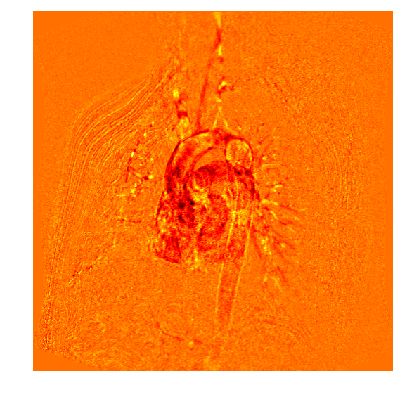

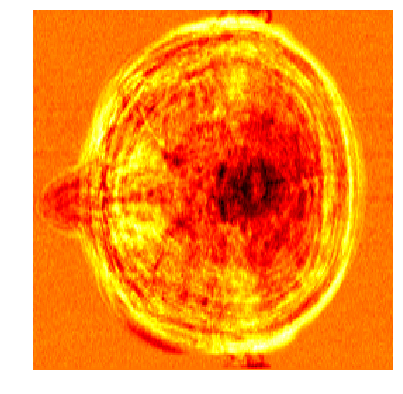

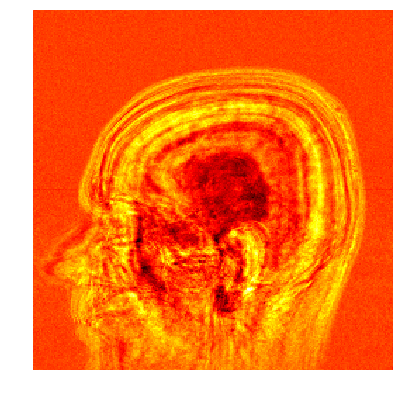

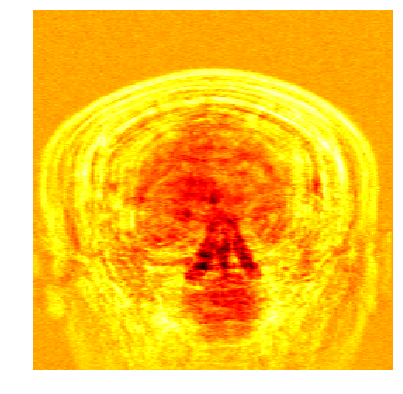

In [21]:
make_image(subclavia_rep, 'subclavia_entropy.png', (5, 5))
make_image(top_rep, 'toprep_entropy.png', (5, 5))
make_image(side_rep, 'siderep_entropy.png', (5, 5))
make_image(front_rep, 'fontrep_entropy.png', (5, 5))

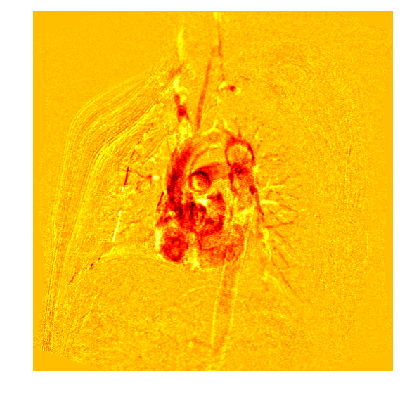

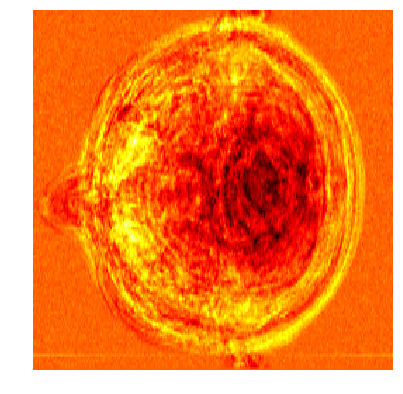

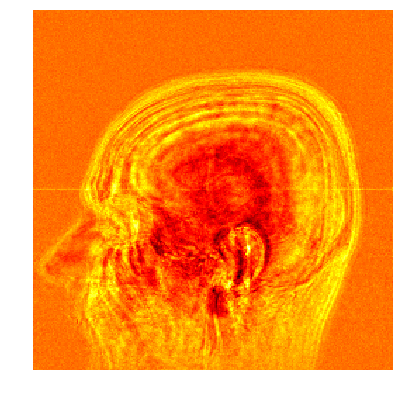

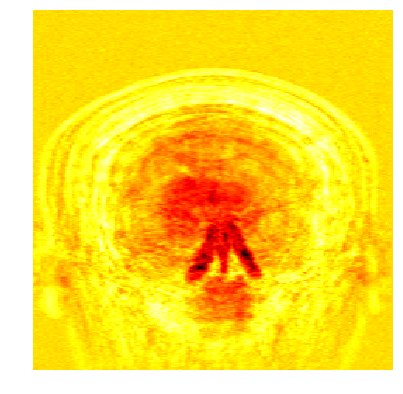

In [22]:
make_image(subclavia_rep_real, 'subclavia_entropy_real.png', (5, 5))
make_image(top_rep_real, 'toprep_entropy_real.png', (5, 5))
make_image(side_rep_real, 'siderep_entropy_real.png', (5, 5))
make_image(front_rep_real, 'fontrep_entropy_real.png', (5, 5))

In [23]:
subclavia_rep_order = get_rank_image(subclavia, order_subclavia, (512, 512))
front_rep_order = get_rank_image(mri_front, order_front, (256, 256))
side_rep_order = get_rank_image(mri_side, order_side, (256, 256))
top_rep_order = get_rank_image(mri_top, order_top, (256, 256))

In [24]:
subclavia_rep_order_real = get_rank_image(subclavia, order_subclavia_real, (512, 512))
front_rep_order_real = get_rank_image(mri_front, order_front_real, (256, 256))
side_rep_order_real = get_rank_image(mri_side, order_side_real, (256, 256))
top_rep_order_real = get_rank_image(mri_top, order_top_real, (256, 256))

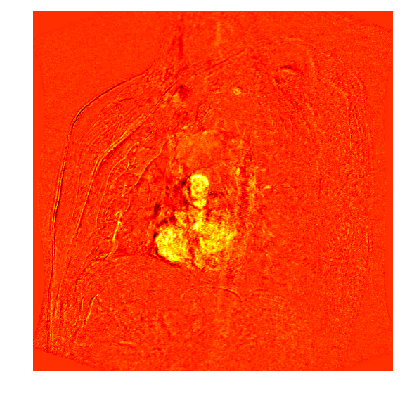

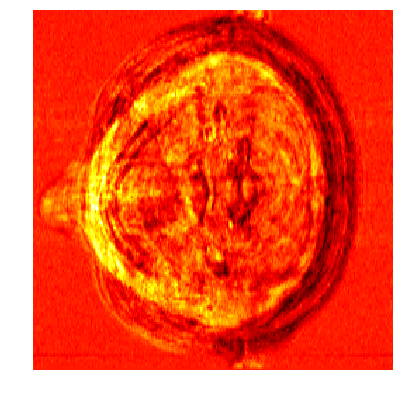

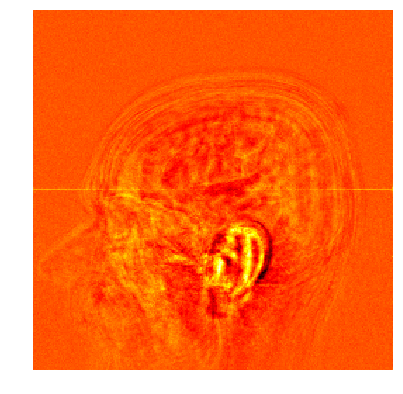

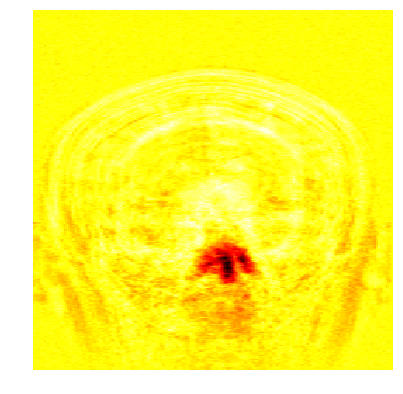

In [25]:
make_image(subclavia_rep_order, 'subclavia_order.png', (5, 5))
make_image(top_rep_order, 'toprep_order.png', (5, 5))
make_image(side_rep_order, 'siderep_order.png', (5, 5))
make_image(front_rep_order, 'fontrep_order.png', (5, 5))

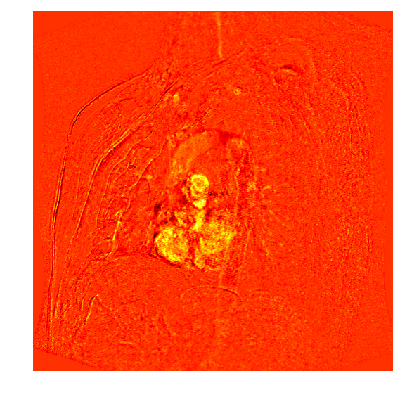

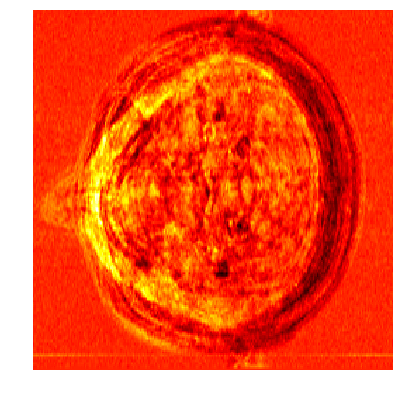

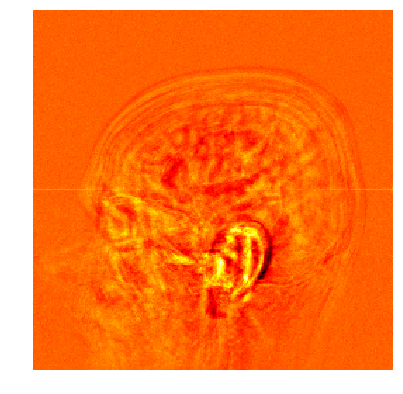

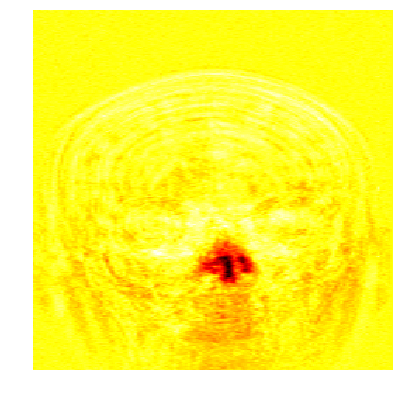

In [26]:
make_image(subclavia_rep_order_real, 'subclavia_order_real.png', (5, 5))
make_image(top_rep_order_real, 'toprep_order_real.png', (5, 5))
make_image(side_rep_order_real, 'siderep_order_real.png', (5, 5))
make_image(front_rep_order_real, 'fontrep_order_real.png', (5, 5))

In [14]:
save_inc_reps(subclavia, entropy_subclavia, "inc_reps_subclavia_entropy.npy", (512, 512))
save_inc_reps(mri_front, entropy_front, "inc_reps_front_entropy.npy", (256, 256))
save_inc_reps(mri_top, entropy_top, "inc_reps_top_entropy.npy", (256, 256))
save_inc_reps(mri_side, entropy_side, "inc_reps_side_entropy.npy", (256, 256))

save_inc_reps(subclavia, order_subclavia, "inc_reps_subclavia_order.npy", (512, 512))
save_inc_reps(mri_front, order_front, "inc_reps_front_order.npy", (256, 256))
save_inc_reps(mri_top, order_top, "inc_reps_top_order.npy", (256, 256))
save_inc_reps(mri_side, order_side, "inc_reps_side_order.npy", (256, 256))

In [14]:
save_inc_reps(subclavia, entropy_subclavia, "inc_reps_subclavia_entropy.npy", (512, 512))
save_inc_reps(mri_front, entropy_front, "inc_reps_front_entropy.npy", (256, 256))
save_inc_reps(mri_top, entropy_top, "inc_reps_top_entropy.npy", (256, 256))
save_inc_reps(mri_side, entropy_side, "inc_reps_side_entropy.npy", (256, 256))

save_inc_reps(subclavia, order_subclavia, "inc_reps_subclavia_order.npy", (512, 512))
save_inc_reps(mri_front, order_front, "inc_reps_front_order.npy", (256, 256))
save_inc_reps(mri_top, order_top, "inc_reps_top_order.npy", (256, 256))
save_inc_reps(mri_side, order_side, "inc_reps_side_order.npy", (256, 256))